In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expi
from sklearn.metrics import mean_squared_error
# import plotly.express as px
# import plotly.io as pio
# from plotly.subplots import make_subplots

In [4]:
import os
os.getcwd()

'c:\\Users\\jacob\\OneDrive - University of Louisville\\Projects\\Dissertation\\PhaseI\\data_analysis\\TRANSONIC\\TRANSONIC\\notebooks'

In [4]:
# Visualize distriubtion of LFR_DZ_CSTR parameters
optimal_parameters_df = pd.read_csv(
    '../results/LFR_DZ_CSTR/results/eval_outputs.csv', 
    index_col=0, 
    header=0
)

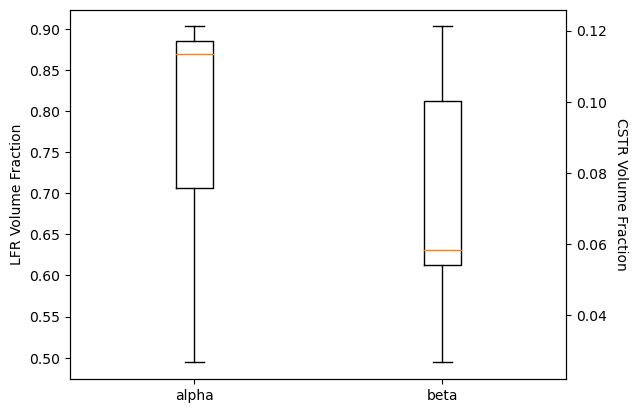

In [18]:
#

fig, ax = plt.subplots()
ax.boxplot(
    optimal_parameters_df['alpha'], 
    labels=['alpha'],
    notch=False
)

ax2 = ax.twinx()

ax2.boxplot(
    optimal_parameters_df['beta'], 
    positions=[2], labels=['beta'],
    notch=False
)
ax.set_ylabel('LFR Volume Fraction')
ax2.set_ylabel('CSTR Volume Fraction', rotation=-90, labelpad=15)
plt.show()

In [11]:
subfig = make_subplots(specs=[[{"secondary_y": True}]])


alpha_fig = px.box(optimal_parameters_df,
             y=['alpha'], 
             points='all',
             width=900,
             height=400
)

beta_fig = px.box(optimal_parameters_df,
             y=['beta'],
             points='all',
             width=900,
             height=400
)

beta_fig.update_traces(yaxis='y2')

subfig.add_traces(alpha_fig.data + beta_fig.data)

subfig.for_each_trace(
    lambda t: t.update(line=dict(color=t.marker.color))
)

pio.write_image(
    subfig,
    '../results/LFR_DZ_CSTR/results/alpha_beta_boxplot.png',
    format='png',
    width=1080,
    height=1080
)

subfig.show()

# IMPORT NECESSARY CLASSES

- The following models include:
    - The general model class necessary for specific, child model classes
    - The LFR_DZ_CSTR model class that represents an LFR in series with a CSTR
    - The SINGLE_DISPERSION model class that uses the Taylor Dispersion equation as a model


In [5]:

import numpy as np 
from scipy.optimize import curve_fit, differential_evolution

class Model:
    def __init__(self, initial_guess=None):
        self.initial_guess = initial_guess


    def fit(self, xdata, ytrue, polish_bool=True):
        '''
        A two-step optimization procedure where differential evolution is 
        applied first and then a polishing step with a gradient based method 
        is used. Fits the model instance to the provided ground truth data.

        Parameters:
        - xdata : np.array
            time sequence to fit over
        - ytrue : np.array
            the ground truth data to fit the model to 
        - polish_bool : bool 
            Bool for whether or not to perform the gradient based optimization step

        Returns: 
        - Nothing, but sets model attribute "params" to optimally found parameters
        '''

        result = differential_evolution(self.objective, 
                                        self.bounds, 
                                        args=(xdata, ytrue),
                                        polish=polish_bool,
                                        seed=69)
        self.params = result.x


    def scipy_curve_fit(self, xdata, ydata, bounds=None):
        try: 
            popt, pcov = curve_fit(self.function, xdata, ydata, 
                                bounds=bounds , p0=self.initial_guess)
            self.params = popt
        except RuntimeError as e:
            print(f"{e}: Couldn't find optimal parameters")
            self.params = [0, 0, 0]
    
    def predict(self, xdata):
        return self.function(xdata, *self.params)
    
    def function(self, x, *params):
        raise NotImplementedError("This method should be implemented by subclasses.")
    
    def objective(self, params, args):
         raise NotImplementedError("This method should be implemented by subclasses.")


In [21]:

from scipy.special import expi
import numpy as np
from sklearn.metrics import mean_squared_error


class LFR_DZ_CSTR(Model):
    """
    LFR_DZ_CSTR model represents a system where all flow first enters a 
    laminar flow reactor (LFR).The outlet of the LFR goes directly to the 
    CSTR. The model has two primary parameters:
    - a : the fraction of real volume that is described by the LFR
    - b : the fraction of real volume that is described by the CSTR

    Attributes:
    - dt : the amount of time during which the tracer was injected (CFD sim dt)
    - tau : the spacetime of the reactor defined by volume / flow rate
    - bounds : the bounds for the model parameters which are optimized for
    - C0 : initial concnetration injected in pulse experiment

    Notes: 
    - This is currently the best model for Phase I of Miller's dissertation
    - A third parameter that is not a degree of freedom, call it c, is found by
      subtracting the sum of a and b from 1. This is representative of the 
      fraction of the volume represented as a stagnant or deadzone. 
    """

    def __init__(self, dt, tau, bounds=None, initial_guess=None, C0=1):
        """
        Initializes the model 

        Parameters: 
        - See class level doc string
        """

        super().__init__(initial_guess=initial_guess)
        self.dt = dt
        self.tau = tau
        self.bounds = bounds
        self.C0 = C0
    

    def exp_term(self, t, m):
        """
        This is a necessary term for calculating the outlet of the CSTR
        """

        return np.exp(m*t)*(m*t + 1)/t**2

    def expi_term(self, t, m):
        """
        This is a necessary term for calculating the outlet of the CSTR
        """

        return m**2 * expi(m*t)

    def outlet_concentration(self, t, a, b):
        """
        Calculates the concentration leaving the CSTR for some time, t

        Parameters:
        - a : the fraction of volume given by the LFR
        - b : the fraction of volume given by the CSTR

        Returns:
        - The concentration leaving the CSTR at time t

        """

        tau_LFR = a*self.tau
        tau_CSTR = b*self.tau

        m = 1 / tau_CSTR
        n = tau_LFR**2 * self.C0 * self.dt / 2 / tau_CSTR
        C_0 = 0
        C_IC = n*0.5*(self.exp_term(tau_LFR/2, m) - self.expi_term(tau_LFR/2, m))
        C_1 = (C_IC - 0.5*n*(self.exp_term(t, m) - self.expi_term(t, m)))/np.exp(m*t)
        C_CSTR_out = np.where(t < tau_LFR/2, C_0, C_1)
        return C_CSTR_out
    
    def function(self, xdata, a, b):
        return self.outlet_concentration(xdata, a, b)

    def objective(self, params, xdata, ytrue):
        '''
        This was the first deployment of the objective function method in a 
        model class. 

        Parameters: 
        - params : a tuple containing the model parameters a and b
        - xdata : the time series to predict over
        - ytrue : the CFD RTD data

        Returns:
        - np.float : the mean squared error term plus a penalty constraint
        '''

        a, b = params
        penalty = 0

        # Penalty term to ensure that sum of a and b is never greater than 1 
        if a + b > 1:
            penalty = 1000 * (a + b - 1)**2
        y_predicted = self.function(xdata, a, b)
        return mean_squared_error(ytrue, y_predicted) + penalty

# PARAMETER RECOVERY TESTS
- **Purpose**: The following is performed to validate our choice of optimization/curve fitting strategy in our software
- **Process**: Generate a set of psuedo-random alpha and beta values. Use the pairs of parameter values to generate a ground truth curve using the "function" method of the class. Use the result of the function method as the "ytrue" data in the model's "curve_fit" method.
- **Desired Outcome**: The optmiziation procedure should, within an error limit, return the original input parameters.  

In [22]:
# We need lists of alpha and beta values. We will pull from a uniform distriubtion between 0.4 and 1 for 
# alpha values and 1e-2 and 0.3 for beta values. These ranges are chosen from the combined consideration of the 
# model arteries and real patient arteries. 
np.random.seed(11)
alphas = np.random.uniform(0.4, 1.0, 64)
betas = np.random.uniform(1e-2, 0.3, 64)  # Setting lower bound too low will result in error from differential evolution optimizer


pairs = list(zip(alphas, betas))

# Filter the pairs such that no pairs exist where the sum is greater than one. This is a model constraint. 
pairs = [(a, b) for a, b in pairs if a+b<=1]

# Convert pairs to a numpy array
pairs = np.array(pairs)
print(len(pairs))
pairs

50


array([[0.50816181, 0.24390437],
       [0.41168514, 0.23170242],
       [0.67793112, 0.19925827],
       [0.65212216, 0.19624231],
       [0.69125626, 0.28765878],
       [0.40766849, 0.10682358],
       [0.69242296, 0.22409326],
       [0.46524164, 0.11604435],
       [0.91429255, 0.03175058],
       [0.49905197, 0.01560958],
       [0.41229017, 0.14130016],
       [0.47004236, 0.19062186],
       [0.58982039, 0.22458594],
       [0.49474738, 0.13141239],
       [0.85538775, 0.11660911],
       [0.89096521, 0.05901836],
       [0.60677469, 0.240223  ],
       [0.59127928, 0.25158085],
       [0.46699674, 0.22292177],
       [0.45037189, 0.26383543],
       [0.75972604, 0.21185919],
       [0.43340421, 0.06597524],
       [0.68787837, 0.23261335],
       [0.64100589, 0.10688404],
       [0.83070951, 0.10247237],
       [0.76123843, 0.174804  ],
       [0.73143029, 0.20102078],
       [0.60283243, 0.07322098],
       [0.54392481, 0.25503217],
       [0.87786145, 0.09762776],
       [0.

In [23]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
# Define a toy system
# These values are chosen as they are similar to those seen in model and real arteries
dt = 1e-6
mean_RT = 0.1

# Initialize the System
model = LFR_DZ_CSTR(dt, mean_RT, bounds=[(0.01, 0.99), (0.01, 0.99)])

# Define length of time to evaluate model
t = np.linspace(0, 3*mean_RT, 5000)

# Initialize an array to store the fitted parameters
fitted_parameters = np.zeros((len(pairs), 2))

for i, pair in tqdm(enumerate(pairs)):
    Ct = model.function(t, *pair)
    model.fit(t, Ct)
    fitted_parameters[i, :] = model.params



ModuleNotFoundError: No module named 'tqdm'

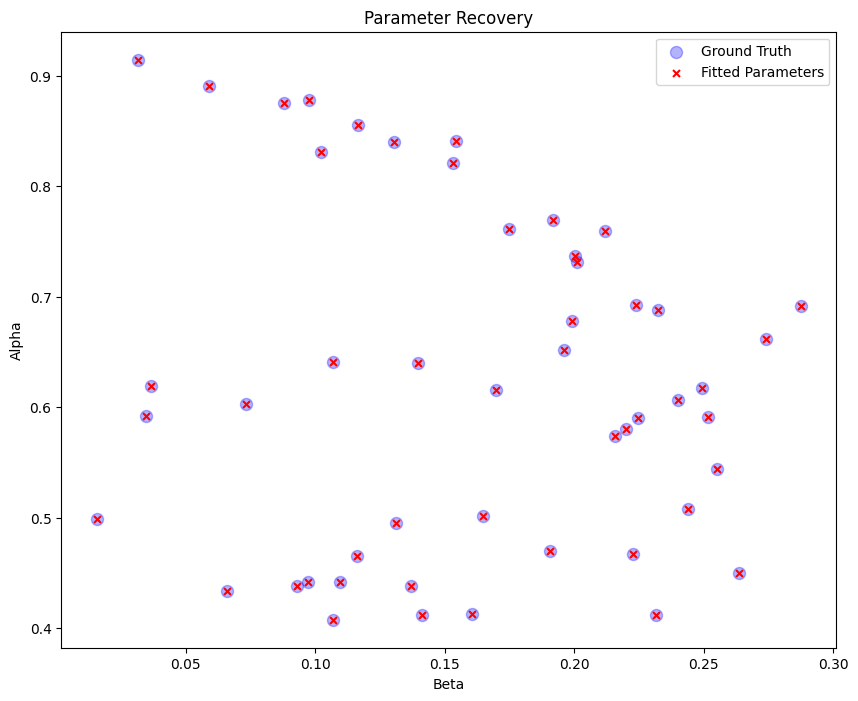

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(pairs[:, 1], pairs[:, 0], color='blue', alpha=.3, s=75, label='Ground Truth')
plt.scatter(fitted_parameters[:, 1], fitted_parameters[:, 0], color='red', marker='x', s=25, label='Fitted Parameters')
plt.xlabel('Beta')
plt.ylabel('Alpha')
plt.legend()
plt.title('Parameter Recovery')
plt.show()

# Guassian Noise Test
- **Purpose**: To ensure that the optimization algorithm is robust to measurement noise that may be seen in real thermodilution curves.
- **Method**: Create an array of random samples from a Guassian distribution with mean of 0 and add it to the Ct ground truth curve.
- **Desired Outcome**: That there is no significant difference between the curve fitted to the ground truth data and that fit to the ground truth + noise 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Define a toy system
# These values are chosen as they are similar to those seen in model and real arteries
dt = 1e-6
mean_RT = 0.1

# Choose a random set of parameters to use
true_parameters = pairs[47]


# Initialize the System
model = LFR_DZ_CSTR(dt, mean_RT, bounds=[(0.01, 0.99), (0.01, 0.99)])


# Define length of time to evaluate model
t = np.linspace(0, 3*mean_RT, 5000)


# Generate the ground truth data from the initialized model
Ct = model.function(t, *true_parameters)


# Generate an array of Guassian noise that is 1% of the maximum value
noise = np.random.normal(0, 0.01*max(Ct), len(Ct))
Ct_fuzzy = Ct + noise


# Fit the model to the fuzzy data and get the fitted parameters
model.fit(t, Ct_fuzzy)
fitted_parameters = model.params


# Format parmater string needed for comparing the true values to those found by the optimizer from the fuzzy data
message = f'True Parameters: ({true_parameters[0]:.3f}, {true_parameters[1]:.3f})' + '\n' \
         + f'Fitted Parameters: ({fitted_parameters[0]:.3f}, {fitted_parameters[1]:.3f})'




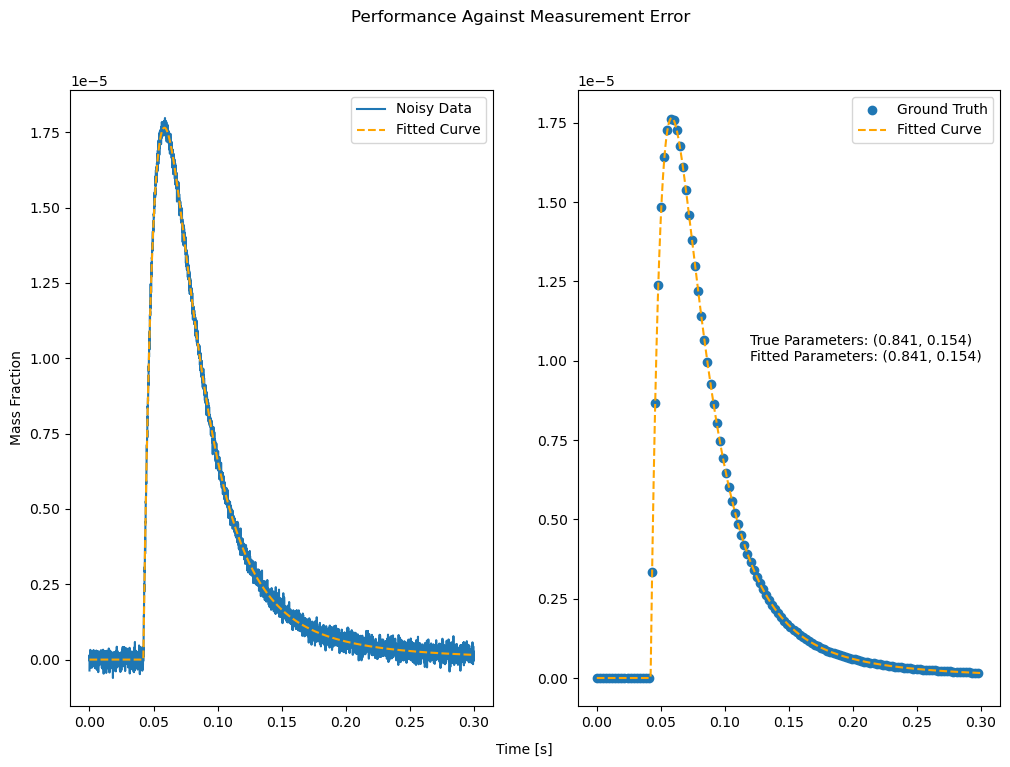

In [ ]:
# Create two plots to show how the optimizer parameters compare to the noisy data and the ground truth data

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(t, Ct_fuzzy, label='Noisy Data')
ax[0].plot(t, model.function(t, *fitted_parameters), label='Fitted Curve', c='orange', linestyle='--')


ax[1].scatter(t[::40], Ct[::40], label='Ground Truth')
ax[1].plot(t, model.function(t, *fitted_parameters), label='Fitted Curve', c='orange', linestyle='--')


ax[0].set_ylabel('Mass Fraction')

ax[0].legend()
ax[1].legend()

ax[1].text(x=0.12, y=1e-5, s=message)

fig.text(0.48, 0.05, s='Time [s]')
fig.suptitle('Performance Against Measurement Error')

plt.show()



# SOBOL GLOBAL SENSITIVITY ANALYSIS
- **Purpose**: To observe the model's sensitivity to its two parameters 
- **Method**: I will edit my LFR_DZ_CSTR model by recasting the parameters a and b to u and v where u and v are independent of another another but are related through a and b. I will then use Sobol's method to calculate the sensitivity indices. 
- **Desired Outcome**: have a measurement of the model's sensitivity to changes in its two parameters. 

In [46]:

from scipy.special import expi
import numpy as np
from sklearn.metrics import mean_squared_error


class LFR_DZ_CSTR(Model):
    """
    LFR_DZ_CSTR model represents a system where all flow first enters a 
    laminar flow reactor (LFR).The outlet of the LFR goes directly to the 
    CSTR. The model has two primary parameters:
    - a : the fraction of real volume that is described by the LFR
    - b : the fraction of real volume that is described by the CSTR

    Attributes:
    - dt : the amount of time during which the tracer was injected (CFD sim dt)
    - tau : the spacetime of the reactor defined by volume / flow rate
    - bounds : the bounds for the model parameters which are optimized for
    - C0 : initial concnetration injected in pulse experiment

    Notes: 
    - This is currently the best model for Phase I of Miller's dissertation
    - A third parameter that is not a degree of freedom, call it c, is found by
      subtracting the sum of a and b from 1. This is representative of the 
      fraction of the volume represented as a stagnant or deadzone. 
    """

    def __init__(self, dt, tau, bounds=None, initial_guess=None, C0=1):
        """
        Initializes the model 

        Parameters: 
        - See class level doc string
        """

        super().__init__(initial_guess=initial_guess)
        self.dt = dt
        self.tau = tau
        self.bounds = bounds
        self.C0 = C0
    

    def exp_term(self, t, m):
        """
        This is a necessary term for calculating the outlet of the CSTR
        """

        return np.exp(m*t)*(m*t + 1)/t**2

    def expi_term(self, t, m):
        """
        This is a necessary term for calculating the outlet of the CSTR
        """

        return m**2 * expi(m*t)

    def outlet_concentration(self, t, a, b):
        """
        Calculates the concentration leaving the CSTR for some time, t

        Parameters:
        - a : the fraction of volume given by the LFR
        - b : the fraction of volume given by the CSTR

        Returns:
        - The concentration leaving the CSTR at time t

        """
        
        # Now casting u = a and v = (1-a)*b

        tau_LFR = a*self.tau
        tau_CSTR = (1-a)*b*self.tau

        m = 1 / tau_CSTR
        n = tau_LFR**2 * self.C0 * self.dt / 2 / tau_CSTR
        C_0 = 0
        C_IC = n*0.5*(self.exp_term(tau_LFR/2, m) - self.expi_term(tau_LFR/2, m))
        C_1 = (C_IC - 0.5*n*(self.exp_term(t, m) - self.expi_term(t, m)))/np.exp(m*t)
        C_CSTR_out = np.where(t < tau_LFR/2, C_0, C_1)
        return C_CSTR_out
    
    def function(self, xdata, a, b):
        return self.outlet_concentration(xdata, a, b)

    def objective(self, params, xdata, ytrue):
        '''
        This was the first deployment of the objective function method in a 
        model class. 

        Parameters: 
        - params : a tuple containing the model parameters a and b
        - xdata : the time series to predict over
        - ytrue : the CFD RTD data

        Returns:
        - np.float : the mean squared error term plus a penalty constraint
        '''

        a, b = params

        # Eliminated the penalty term enforcing a+b to be less than one.
        # No longer necessary now that a and b are independent. 

        y_predicted = self.function(xdata, a, b)
        return mean_squared_error(ytrue, y_predicted)

In [50]:
from SALib.sample import saltelli
from SALib.analyze import sobol


def Y_generator(samples, time_stamps):
    Y = np.zeros([samples.shape[0], len(time_stamps)])

    for i, t in enumerate(time_stamps):
        # Generate and record result for each set of parameters
        for j, X in enumerate(samples):
            Y[j, i] = model.function(t, *X)
    return Y

def filter_nan(Yi, samples):
    # Find and drop non finite results that are due to unstable pairs of a and b
    non_finite_indices = np.where(~np.isfinite(Y))

    # Create a mask that will be used to drop rows with nan values
    mask = np.ones(len(Y), dtype=bool)
    mask[non_finite_indices[0]] = False
    Y_filtered = Y[mask]

    # Apply mask to param_samples as well for consistency
    samples = samples[mask]

    # After dropping nans, make sure that Y_filtered is equal to 2^n
    # I chose 2^10 -> 1024 which converts to the first 6144 rows
    Y_filtered = Y_filtered[:6144, :]  
    return Y_filtered, samples



# Define the problem setup
# NOTE: The bounds for b were determine from the distribution of b values 
# from parameter recovery and solving for min and max values using v=(1-a)*b
problem = {
    'num_vars': 2,
    'names': ['a', 'b'], 
    'bounds': [[0.5, 0.96], [0.025, 0.216]]
}


# Define a toy system
# These values are chosen as they are similar to those seen in model and real arteries
dt = 1e-6
mean_RT = 0.1

# Initialize the System
model = LFR_DZ_CSTR(dt, mean_RT)

# Choose time stamp to sample model
T = np.linspace(1e-6, 2*mean_RT, 100)

# Generate samples 
param_samples = saltelli.sample(problem, 2048, calc_second_order=True)

Y = Y_generator(param_samples, T)

Y, param_samples = filter_nan(Y, param_samples)



sobol_indices = [sobol.analyze(problem, Yi, calc_second_order=True) \
                 for Yi in Y.T]

C:\Users\jacob\AppData\Local\Temp\ipykernel_41876\314625388.py:55: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_samples = saltelli.sample(problem, 2048, calc_second_order=True)
C:\Users\jacob\AppData\Local\Temp\ipykernel_41876\2540848093.py:47: RuntimeWarning: overflow encountered in exp
  return np.exp(m*t)*(m*t + 1)/t**2
C:\Users\jacob\AppData\Local\Temp\ipykernel_41876\2540848093.py:78: RuntimeWarning: invalid value encountered in scalar subtract
  C_1 = (C_IC - 0.5*n*(self.exp_term(t, m) - self.expi_term(t, m)))/np.exp(m*t)
C:\Users\jacob\AppData\Local\Temp\ipykernel_41876\2540848093.py:78: RuntimeWarning: overflow encountered in exp
  C_1 = (C_IC - 0.5*n*(self.exp_term(t, m) - self.expi_term(t, m)))/np.exp(m*t)
C:\Users\jacob\AppData\Local\Temp\ipykernel_41876\2540848093.py:47: RuntimeWarning: overflow encountered in scalar divide
  return np.exp(m*t)*(m*t + 1)/t**2
C:\Users\jacob\AppData\Local\Temp\ipykernel_41

In [64]:
S1_a = [sobol_indices[i]['S1'][0] for i in range(len(sobol_indices))]

S1_b = [sobol_indices[i]['S1'][1] for i in range(len(sobol_indices))]

ST_a = [sobol_indices[i]['ST'][0] for i in range(len(sobol_indices))]

ST_b = [sobol_indices[i]['ST'][1] for i in range(len(sobol_indices))]


In [65]:
S1_a = np.array(S1_a)[~np.isnan(S1_a)]

S1_b = np.array(S1_b)[~np.isnan(S1_b)]
ST_a = np.array(ST_a)[~np.isnan(ST_a)]
ST_b = np.array(ST_b)[~np.isnan(ST_b)]

print(len(S1_a), len(S1_b), len(ST_a), len(ST_b))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False] [ True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False 

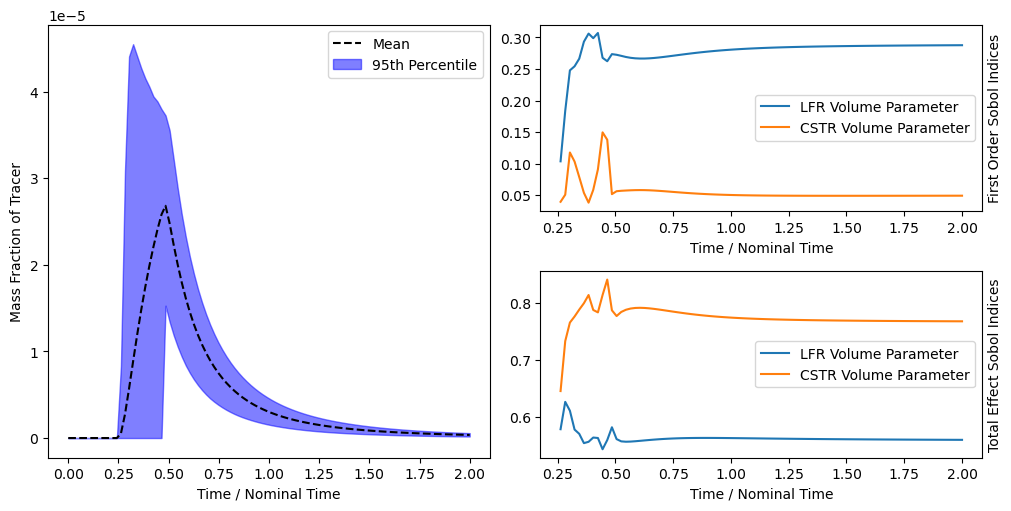

In [67]:
prediction_interval=95

fig = plt.figure(figsize=(10, 5), constrained_layout=True)
gs = fig.add_gridspec(2, 2)
axs0 = fig.add_subplot(gs[:, 0])
axs1 = fig.add_subplot(gs[0, 1])
axs2 = fig.add_subplot(gs[1, 1])

axs0.plot(T/mean_RT, Y.mean(axis=0), color='black', linestyle='--', label='Mean')
axs0.fill_between(T/mean_RT, 
                 np.percentile(Y, 50 - prediction_interval/2, axis=0),
                 np.percentile(Y, 50 + prediction_interval/2, axis=0),
                 alpha=0.5,
                 color='blue',
                 label='95th Percentile')
axs0.set_xlabel('Time / Nominal Time')
axs0.set_ylabel('Mass Fraction of Tracer')
axs0.legend()

T_adj = T[13:] 

axs1.plot(T_adj/mean_RT, S1_a, label='LFR Volume Parameter')
axs1.plot(T_adj/mean_RT, S1_b, label='CSTR Volume Parameter')
axs1.set_xlabel('Time / Nominal Time')
axs1.set_ylabel('First Order Sobol Indices')
axs1.yaxis.set_label_position("right")
axs1.legend()

axs2.plot(T_adj/mean_RT, ST_a, label='LFR Volume Parameter')
axs2.plot(T_adj/mean_RT, ST_b, label='CSTR Volume Parameter')
axs2.set_xlabel('Time / Nominal Time')
axs2.set_ylabel('Total Effect Sobol Indices')
axs2.yaxis.set_label_position("right")
axs2.legend()